In [1]:
import os
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
import base64
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.lines import Line2D  # For custom legend

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


In [2]:
# Folders that I will use for the analysis
folders = ["Memento_V01", "Memento_V02", "Memento_V03", "Memento_V04", "ShutterIsland_V01"]
# Create the new df_perf DataFrame where the values of perfomance metrics are the mean of the same Test_ID in each "nginx_metrics.csv" file in the folders
import os

def load_and_average_perf_data(folders, filename="nginx_metrics.csv"):
    all_data = []

    for folder in folders:
        filepath = os.path.join(folder, filename)
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            all_data.append(df)
        else:
            print(f"Warning: File not found in {folder}")

    if not all_data:
        print("No data loaded.")
        return pd.DataFrame()

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    # Metrics to average
    metrics = [
        "Throughput", "Avg_Latency", "P50_Latency", "P75_Latency",
        "P90_Latency", "P95_Latency", "P99_Latency", "Max_Latency", "Errors"
    ]

    # Columns to group by (everything else except those being averaged)
    fixed_columns = [col for col in combined_df.columns if col not in metrics]

    # Group by Test_ID (or fixed fields) and compute mean of metrics
    averaged_df = combined_df.groupby("Test_ID", as_index=False).agg({
        **{col: 'first' for col in fixed_columns if col != "Test_ID"},
        **{metric: 'mean' for metric in metrics}
    })

    return averaged_df

# Example usage:
# df_perf = load_and_average_perf_data(folders)
df_perf = load_and_average_perf_data(folders)

In [3]:
# Keep only rows where Given_RPS is in [500, 1500, 2500, 3500]
def filter_by_given_rps(df, rps_values):
    return df[df['Given_RPS'].isin(rps_values)]
df_perf_filtered = filter_by_given_rps(df_perf, [500, 1500, 2500, 3500])
display(df_perf_filtered)

,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
2,1replicas_scenario0_1500rps,1,Baseline0,0,1500,1500.001072,0.086,0.083,0.0,0.103,0.110,0.136,3.099,0.0
4,1replicas_scenario0_2500rps,1,Baseline0,0,2500,2500.006560,0.092,0.088,0.0,0.116,0.131,0.172,3.640,0.0
6,1replicas_scenario0_3500rps,1,Baseline0,0,3500,3500.005229,0.096,0.089,0.0,0.129,0.147,0.198,3.270,0.0
8,1replicas_scenario0_500rps,1,Baseline0,0,500,500.003746,0.088,0.084,0.0,0.101,0.111,0.158,2.738,0.0
9,1replicas_scenario100_1500rps,1,BaselineB0,100,1500,1500.004295,0.084,0.082,0.0,0.100,0.108,0.133,3.400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,4replicas_scenario33_500rps,4,3_iBench_memBW_pods,33,500,500.004118,0.120,0.106,0.0,0.174,0.199,0.273,2.937,0.0
741,4replicas_scenario34_1500rps,4,4_iBench_memBW_pods,34,1500,1500.002209,0.114,0.099,0.0,0.161,0.193,0.284,6.199,0.0
743,4replicas_scenario34_2500rps,4,4_iBench_memBW_pods,34,2500,2500.013178,0.143,0.104,0.0,0.201,0.256,1.024,4.996,0.0
745,4replicas_scenario34_3500rps,4,4_iBench_memBW_pods,34,3500,3500.004883,0.187,0.124,0.0,0.294,0.412,1.622,7.018,0.0


In [4]:
def label_scenarios(df):
    def generate_label(row):
        iid = row['Interference_ID']
        if iid in [0, 1, 2, 3, 4]:
            return f"B{iid}"
        elif 10 <= iid <= 14:
            return f"CPU{iid - 10}"
        elif 20 <= iid <= 24:
            return f"L3_{iid - 20}"
        elif 30 <= iid <= 34:
            return f"MEM{iid - 30}"
        elif 100 <= iid <= 104:
            return f"B{iid - 100}"
        elif 110 <= iid <= 114:
            return f"CPU{iid - 110}"
        elif 120 <= iid <= 124:
            return f"L3_{iid - 120}"
        elif 130 <= iid <= 134:
            return f"MEM{iid - 130}"
        else:
            return f"ID{iid}"

    df = df.copy()
    df['Scenario_Label'] = df.apply(generate_label, axis=1)
    return df

In [5]:
def plot_perf_comparison_by_rps(df_perf, target_rps, metric='P99_Latency', replicas_to_plot=None):
    """
    Plots performance comparison between Case A (ID < 100) and Case B (ID ≥ 100)
    by calling plot_perf_by_rps twice with different data subsets.
    """
    df_perf = label_scenarios(df_perf)
    # Split data into Case A and Case B
    case_a = df_perf[df_perf['Interference_ID'] < 100].copy()
    case_b = df_perf[df_perf['Interference_ID'] >= 100].copy()
    
    # Create figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    
    # Determine which replicas to plot
    all_replicas = sorted(df_perf['Replicas'].unique())
    replicas = replicas_to_plot if replicas_to_plot is not None else all_replicas
    
    # Define interference types and their scenario labels
    interference_types = {
        "CPU": ["B0"] + [f"CPU{i}" for i in range(1, 6)],
        "L3": ["B0"] + [f"L3_{i}" for i in range(1, 6)],
        "MemBW": ["B0"] + [f"MEM{i}" for i in range(1, 6)],
    }
    
    # Plot for each interference type
    for ax, (label, scenario_labels) in zip(axs, interference_types.items()):
        for replica in replicas:
            # Plot Case A (solid line)
            subset_a = case_a[
                (case_a['Given_RPS'] == target_rps) &
                (case_a['Replicas'] == replica) &
                (case_a['Scenario_Label'].isin(scenario_labels))
            ]
            grouped_a = subset_a.groupby('Scenario_Label')[metric].mean()
            y_vals_a = [grouped_a.get(lbl, float('nan')) for lbl in scenario_labels]
            ax.plot(scenario_labels, y_vals_a, marker='o', linestyle='-', 
                    label=f'Case A (R{replica})')
            
            # Plot Case B (dashed line)
            subset_b = case_b[
                (case_b['Given_RPS'] == target_rps) &
                (case_b['Replicas'] == replica) &
                (case_b['Scenario_Label'].isin(scenario_labels))
            ]
            grouped_b = subset_b.groupby('Scenario_Label')[metric].mean()
            y_vals_b = [grouped_b.get(lbl, float('nan')) for lbl in scenario_labels]
            ax.plot(scenario_labels, y_vals_b, marker='s', linestyle='--', 
                    label=f'Case B (R{replica})')
        
        ax.set_title(f'{label} Interference')
        ax.set_xlabel('Scenario')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
    
    axs[0].set_ylabel(metric.replace('_', ' '))
    fig.suptitle(f'{metric.replace("_", " ")} Comparison at RPS={target_rps}\n'
                 f'Solid: Case A (ID<100), Dashed: Case B (ID≥100)')
    axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

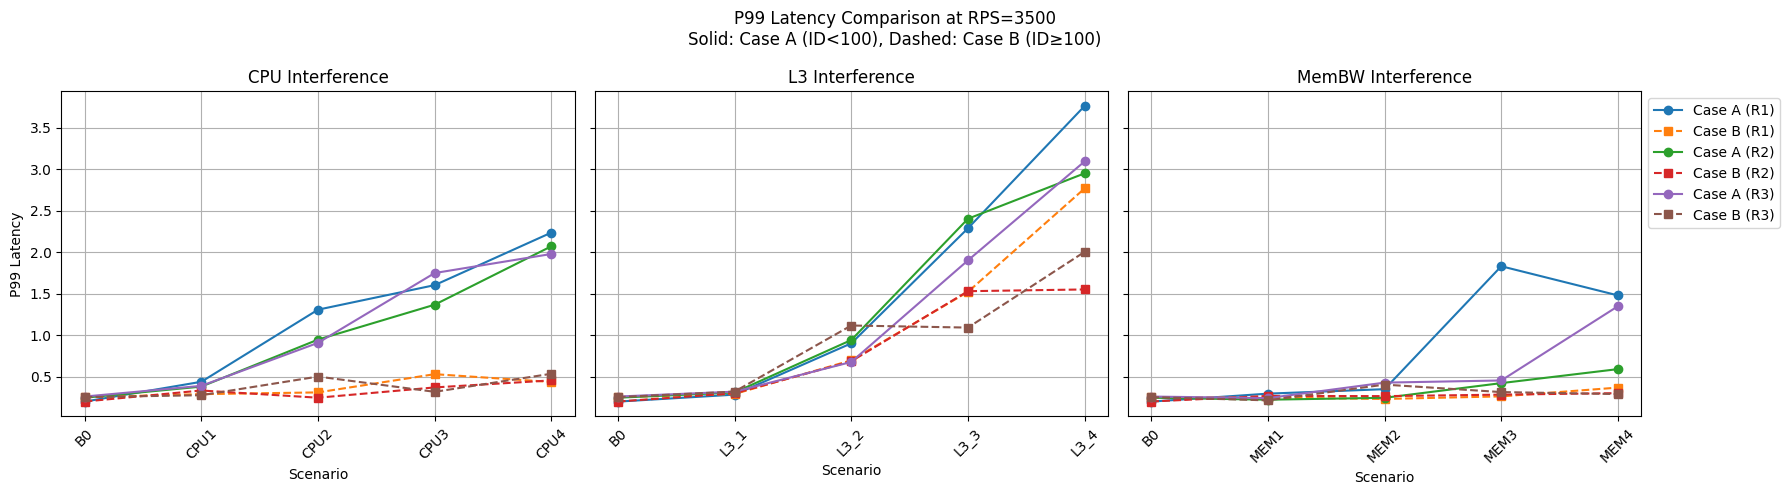

In [9]:
plot_perf_comparison_by_rps(df_perf, target_rps=3500, replicas_to_plot=[1,2,3])